# From Click to Cart: Analyzing Instacart’s Order and Reorder Behavior

## INTRODUCTION 

Online grocery shopping has become an essential part of modern consumer behavior, with platforms like Instacart serving millions of users across North America. Understanding when customers shop, what they buy, and how often they return is critical for optimizing product recommendations, improving retention, and forecasting demand.

In this project, we analyze a large, real world dataset provided by Instacart. The dataset includes millions of anonymized grocery orders across thousands of customers, detailing the timing of purchases, products ordered, and reorder behavior. Using a combination of exploratory data analysis, statistical modeling, forecasting, and A/B testing simulation, we aim to uncover key behavioral patterns and actionable business insights.

## Project Overview
This notebook is divided into several key components:

1. Data Cleaning and Preparation: All Instacart tables (orders, products, aisles, departments, and order-product relationships) are cleaned, deduplicated, and joined where necessary to enable robust analysis.

2. Exploratory Data Analysis (EDA): We explore temporal trends in order volume, user level purchasing frequency, and the popularity of specific products. Key questions include:

    * When do customers shop the most?

    * What are the most popular and most reordered products?

    * How frequently do customers return to shop?

3. A/B Testing Simulation:To model business experimentation, we simulate a marketing intervention using randomized control and treatment groups. We compare reorder rates between these groups and evaluate statistical significance using a t-test.

4. Forecasting: We use Prophet (or ARIMA) to forecast future order volume based on past user behavior. This helps simulate demand planning and inventory optimization scenarios.

5. Statistical Modeling: We build a logistic regression model to predict the likelihood that a product will be reordered, based on order sequence and cart position. Evaluation includes classification metrics and ROC-AUC.

## Hypotheses
1. Shopping Time Behavior: Most customers place orders during daytime hours, particularly between 9 AM and 6 PM, with minimal activity overnight.

2. Weekly Order Patterns: Sunday and Monday will have the highest number of orders, reflecting typical restocking behavior after the weekend.

3. Reordering Trends: A small group of products (especially fruits and staples like bananas) will dominate both first-time orders and reorders, indicating strong customer loyalty and routine habits.

4. Customer Retention: Most users place only one or two orders, with a steep drop-off in repeat behavior, revealing a potential opportunity to improve retention.

5. Marketing Impact: A/B testing will show a measurable difference in reorder rates between control and treatment groups, supporting the value of targeted marketing campaigns.

6. Product Reorder Likelihood: Cart position (e.g., how early a product is added) and frequency of past orders can be strong predictors of whether a product will be reordered.

In [1]:
%matplotlib inline

In [2]:
!pip install prophet

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")  # Optional: sets plot style

from scipy.stats import ttest_ind
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Load Data
orders = pd.read_csv("datasets/instacart_orders.csv", delimiter=';')
products = pd.read_csv("datasets/products.csv", delimiter=';')
aisles = pd.read_csv("datasets/aisles.csv", delimiter=';')
departments = pd.read_csv("datasets/departments.csv", delimiter=';')
order_products = pd.read_csv("datasets/order_products.csv", delimiter=';')

# Create table dictionary
tables = {
    'orders': orders,
    'products': products,
    'aisles': aisles,
    'departments': departments,
    'order_products': order_products
}

# Drop duplicates in all tables
for name in tables:
    tables[name] = tables[name].drop_duplicates()

# Reassign cleaned tables
orders = tables['orders']
products = tables['products']
aisles = tables['aisles']
departments = tables['departments']
order_products = tables['order_products']

# Fix data types
orders[['order_id', 'user_id']] = orders[['order_id', 'user_id']].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)
products['product_id'] = pd.to_numeric(products['product_id'], errors='coerce').fillna(0).astype(int)
aisles['aisle_id'] = pd.to_numeric(aisles['aisle_id'], errors='coerce').fillna(0).astype(int)
departments['department_id'] = pd.to_numeric(departments['department_id'], errors='coerce').fillna(0).astype(int)
order_products['add_to_cart_order'] = pd.to_numeric(order_products['add_to_cart_order'], errors='coerce').fillna(0).astype(int)

# Fill missing product names
products['product_name'] = products['product_name'].fillna('Unknown')


In [5]:
# Utility Functions
# These are reusable helper functions that make it easier to explore and visualize your 

# When column names (cols) is provide , it checks for duplicates based only on those columns.
# When cols is a None, it checks for duplicates across all columns
def check_duplicates(df, cols=None):
    return df[df.duplicated(subset=cols, keep=False)]

# This function creates a bar chart for visualizing summarized data.
def plot_bar(data, title, xlabel, ylabel, color, figsize=(10,6), rotation=0):
    plt.figure(figsize=figsize)
    data.plot(kind='bar', color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rotation)
    plt.tight_layout()
    plt.grid(axis='y')
    plt.show()
    
#This function creates a histogram to show the distribution of numeric values
def plot_hist(data, title, xlabel, ylabel, bins=24, color='skyblue'):
    plt.figure(figsize=(10,6))
    plt.hist(data, bins=bins, color=color, edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.grid(axis='y')
    plt.show()

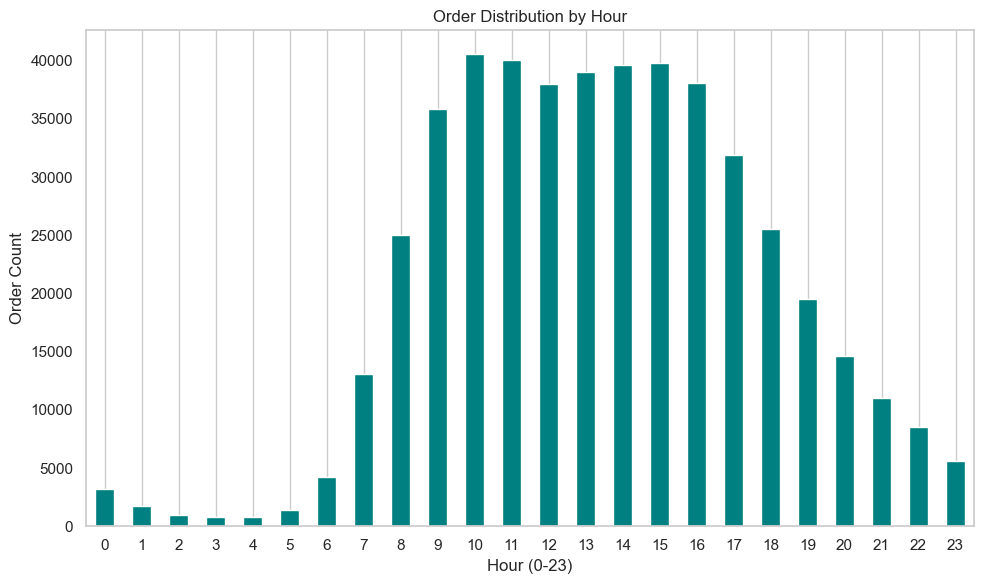

In [6]:
# Time-based Analysis
# Analyze and plot the volume of orders by hour of the day (0–23).
# Helps identify peak shopping times during a 24-hour cycle.
hourly_orders = orders['order_hour_of_day'].value_counts().sort_index()
plot_bar(hourly_orders, 'Order Distribution by Hour', 'Hour (0-23)', 'Order Count', color='teal')

The analysis of orders by hour of the day reveals that Instacart customers are most active between 9:00 AM and 5:00 PM, with a steady decline in activity during the evening and almost no orders placed overnight. This indicates that most grocery shopping on the platform takes place during standard daytime hours, likely aligning with consumer convenience and availability. The sharp peak during late morning to early afternoon hours suggests this is a strategic time for promotions or operational scaling.

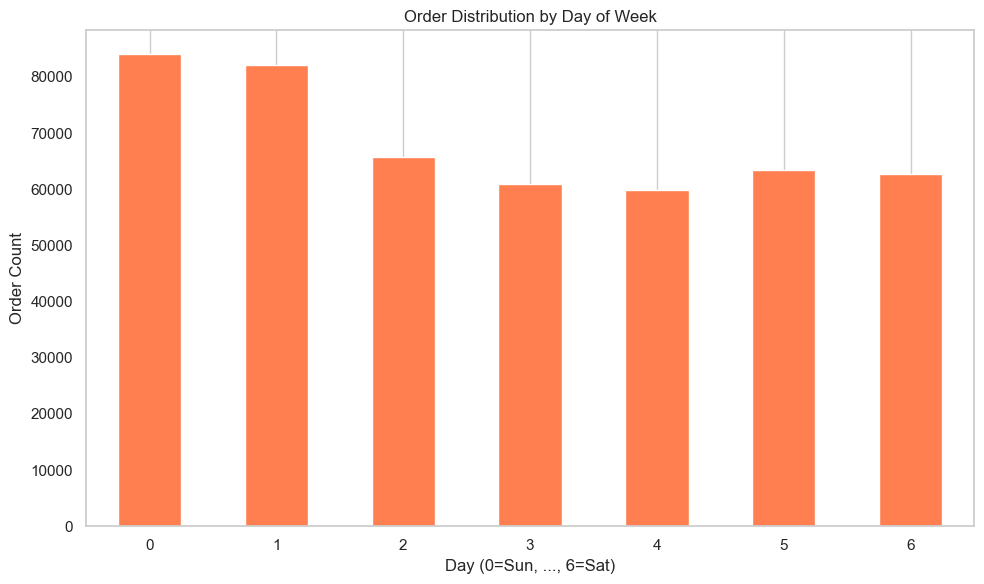

In [7]:
# Analyze and visualize order frequency by day of the week (0 = Sunday, 6 = Saturday).
# Highlights weekly shopping trends and consumer behavior across days.
daily_orders = orders['order_dow'].value_counts().sort_index()
plot_bar(daily_orders, 'Order Distribution by Day of Week', 'Day (0=Sun, ..., 6=Sat)', 'Order Count', color='coral')

When examining order volume by day of the week, Sunday and Monday stand out as the most popular shopping days. This likely reflects common household behavior, restocking groceries after the weekend or preparing for the week ahead. In contrast, Thursday appears to be the least active day for orders. These patterns provide valuable insight for demand forecasting and scheduling promotions or delivery resources accordingly.

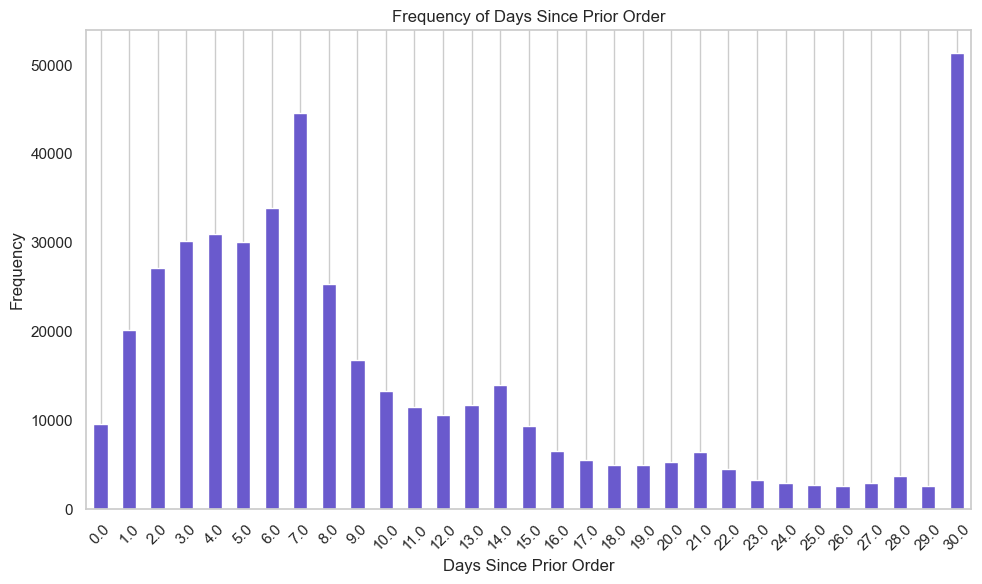

In [8]:
# Plot the distribution of days since a customer’s prior order.
# This reveals common reorder cycles (e.g., weekly or monthly restocking).
days_since_order = orders['days_since_prior_order'].dropna()
plot_bar(days_since_order.value_counts().sort_index(), 'Frequency of Days Since Prior Order',
         'Days Since Prior Order', 'Frequency', color='slateblue', rotation=45)

The distribution of days between consecutive orders shows clear spikes at specific intervals. The 30th day stands out significantly, likely representing a typical monthly restock pattern. There are also noticeable peaks around every 7 days, suggesting many users maintain a weekly shopping routine. These cycles can inform user segmentation strategies and personalized reorder reminder systems.

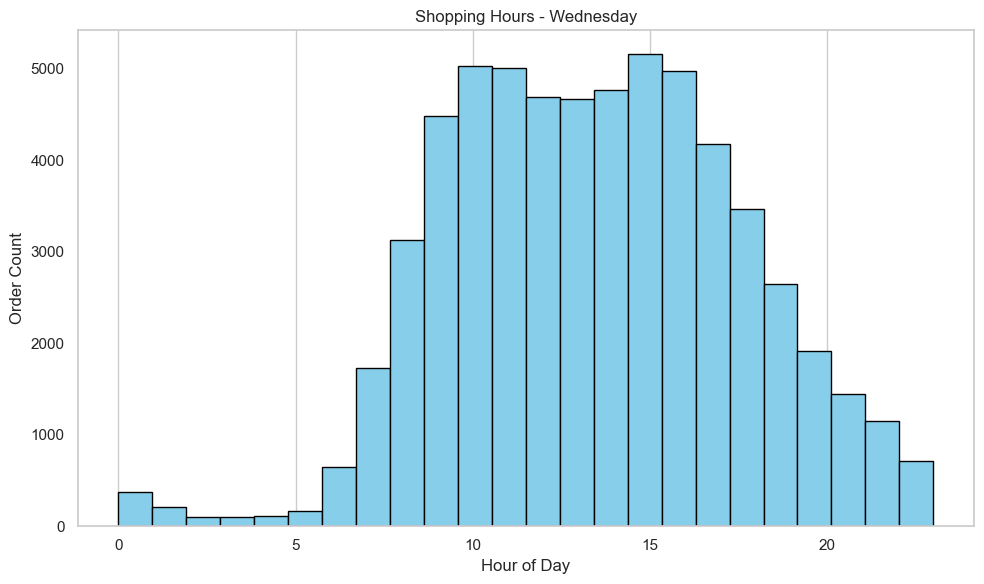

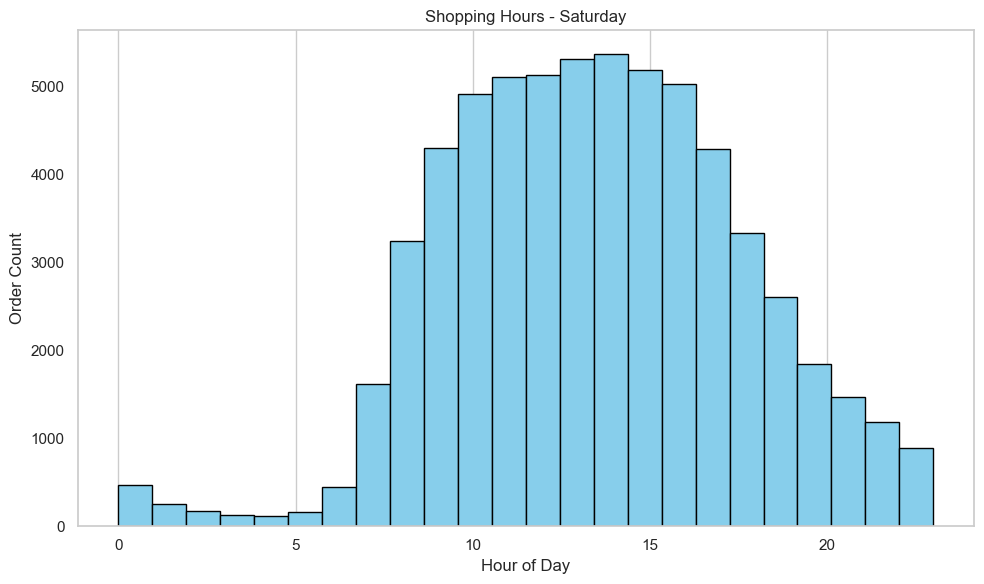

In [9]:
# Wednesday vs Saturday shopping habits
for day, label in zip([3, 6], ['Wednesday', 'Saturday']):
    subset = orders[orders['order_dow'] == day]
    plot_hist(subset['order_hour_of_day'], f'Shopping Hours - {label}', 'Hour of Day', 'Order Count')

A comparison of hourly order distributions on Wednesday and Saturday reveals subtle differences in customer behavior. On both days, order activity is heavily concentrated between 9 AM and 5 PM, with near zero activity overnight. However, Saturday sees slightly more morning activity beginning around 8 AM, while Wednesday peaks closer to midday. These differences may reflect varied routines between weekdays and weekends, offering insights into when users are most responsive to targeted promotions.

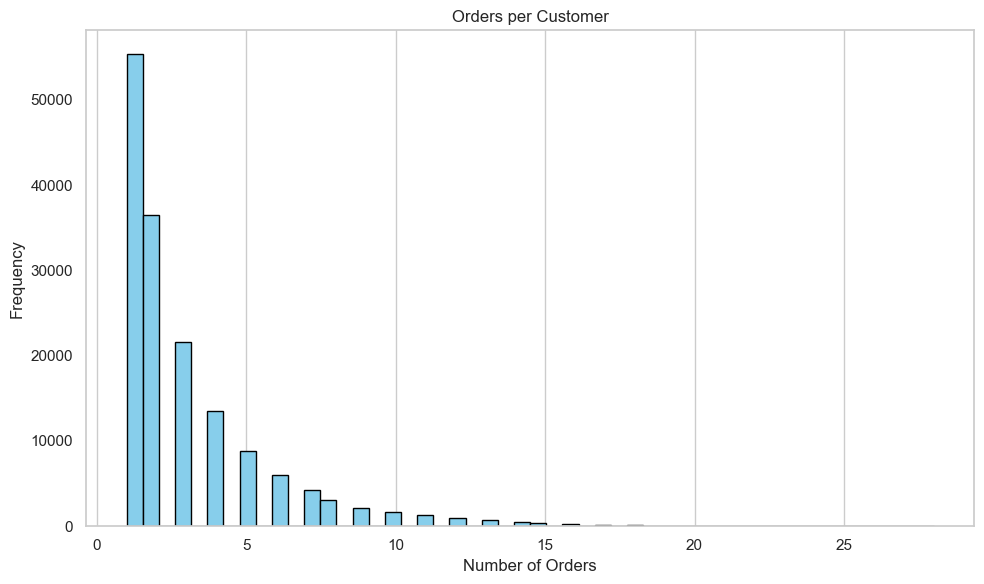

In [10]:
# Orders per customer
orders_per_user = orders.groupby('user_id')['order_id'].nunique()
plot_hist(orders_per_user, 'Orders per Customer', 'Number of Orders', 'Frequency', bins=50)

The distribution of orders per customer is heavily right skewed, showing that most users place only one or two orders. A small subset of customers, however, place significantly more orders, suggesting a group of highly engaged users. This finding emphasizes the importance of customer retention strategies to encourage one-time buyers to become repeat shoppers, as the majority drop off after their first experience.

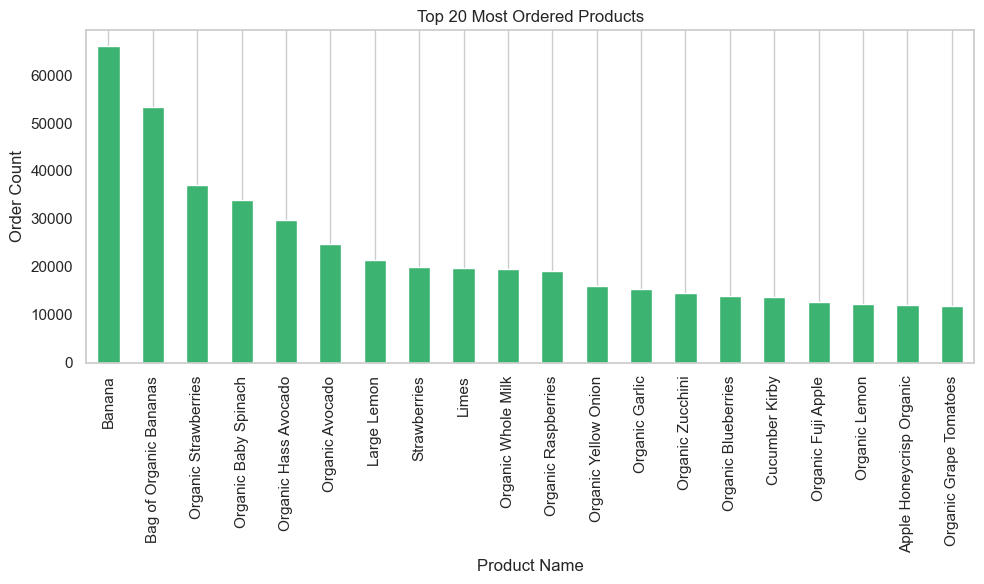

In [11]:
# Product Popularity
merged_df = order_products.merge(products, on='product_id')
top_products = merged_df['product_name'].value_counts().head(20)
plot_bar(top_products, 'Top 20 Most Ordered Products', 'Product Name', 'Order Count', color='mediumseagreen', rotation=90)

Product popularity analysis reveals that Instacart's top 20 most frequently purchased items are dominated by household staples such as bananas, organic spinach, milk, and avocados. These products are likely to be reordered frequently due to their perishable nature and role in daily diets. Retailers could leverage this insight for inventory prioritization and cross selling strategies by promoting related products alongside top selling items.

In [12]:
# Group by product_id and calculate total and count of reorders
reorder_stats = order_products.groupby('product_id')['reordered'].agg(['sum', 'count']).reset_index()

# Calculate reorder rate
reorder_stats['reorder_rate'] = reorder_stats['sum'] / reorder_stats['count']

# Merge with product names
reorder_stats = reorder_stats.merge(products[['product_id', 'product_name']], on='product_id')

# Sort and get top 20 by reorder rate
top_reordered = reorder_stats.sort_values(by='reorder_rate', ascending=False).head(20)

# Display using Pandas styling
top_reordered[['product_name', 'reorder_rate']].style \
    .format({'reorder_rate': '{:.2%}'}) \
    .bar(subset='reorder_rate', color='lightgreen') \
    .set_caption("Top 20 Products by Reorder Rate")

,product_name,reorder_rate
13453,Bone Strength Take Care,100.00%
19195,Vanilla Sandwich Cookies,100.00%
6136,Palmiers- Petite,100.00%
6144,Naturally Sparkling Mineral Water,100.00%
41319,California Dill Pollen & Garlic Goat Cheese & Olive Oil Infusion,100.00%
41310,Pomegranatea,100.00%
19258,Parchment Lined 8 in x 3.75 in x 2.5 in Pans,100.00%
19248,Peanut Butter Pie Ice Cream,100.00%
32273,Chocolate Soy Milk Singles,100.00%
32277,Mocha Chocolate Chip Organic Non-Dairy Frozen Dessert,100.00%


When ranked by reorder rate, some lesser known niche products (including specialty snacks, beverages, and personal care items) achieve a perfect 100% reorder rate. This implies that users who try these products almost always reorder them, suggesting strong product loyalty or satisfaction. These could represent high value items for brand partnerships or targeted loyalty campaigns.

In [13]:
# Simulate A/B groups for users
np.random.seed(42)
orders['treatment'] = np.random.choice([0, 1], size=len(orders))

# Merge to get 'reordered' flag per order
merged_ab = orders.merge(order_products[['order_id', 'reordered']], on='order_id', how='left')

# Group by treatment
ab_results = merged_ab.groupby('treatment')['reordered'].mean()
print("\nA/B Test - Mean Reorder Rate by Group:\n", ab_results)

# T-test for statistical significance
group_0 = merged_ab[merged_ab['treatment'] == 0]['reordered'].dropna()
group_1 = merged_ab[merged_ab['treatment'] == 1]['reordered'].dropna()
t_stat, p_val = ttest_ind(group_0, group_1)
print(f"\nT-Test Result: t-statistic = {t_stat:.4f}, p-value = {p_val:.4f}")



A/B Test - Mean Reorder Rate by Group:
 treatment
0    0.590226
1    0.590779
Name: reordered, dtype: float64

T-Test Result: t-statistic = -1.2006, p-value = 0.2299


Simulating an A/B test on reorder rates revealed virtually no significant difference between the treatment and control groups. The mean reorder rates were nearly identical (around 59%), and the t-test produced a high p-value (≈0.23), indicating no statistically significant effect. This suggests that the simulated marketing intervention did not meaningfully impact reorder behavior, or the sample was not large or distinct enough to detect a difference.

00:30:06 - cmdstanpy - INFO - Chain [1] start processing
00:30:06 - cmdstanpy - INFO - Chain [1] done processing


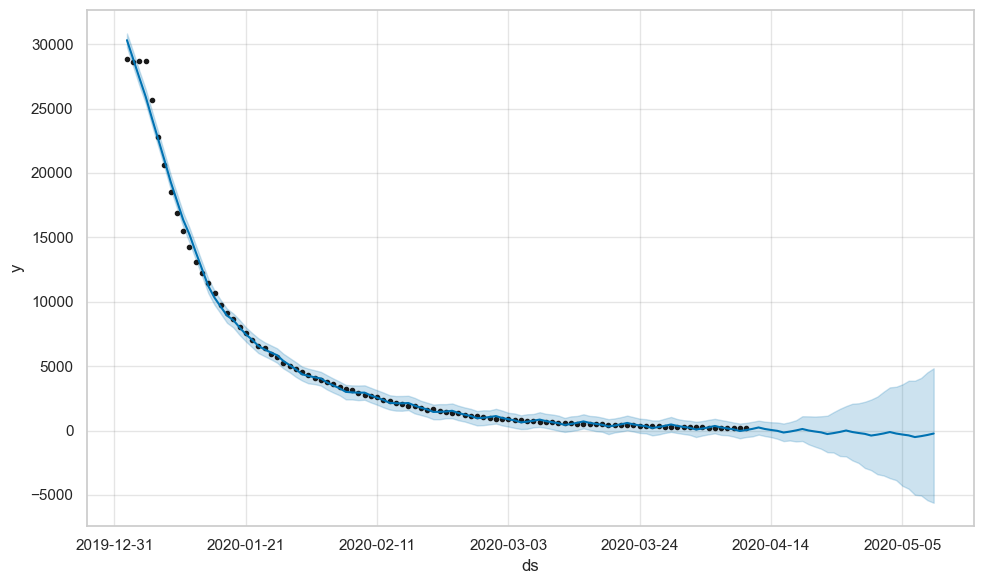

In [14]:
# Forecasting: Daily order volume
daily_volume = orders.groupby('order_number').size().reset_index(name='y')
daily_volume['ds'] = pd.to_datetime(daily_volume['order_number'], unit='D', origin='2020-01-01')

# Prophet Forecast
prophet_df = daily_volume[['ds', 'y']]
prophet_model = Prophet()
prophet_model.fit(prophet_df)
future = prophet_model.make_future_dataframe(periods=30)
forecast = prophet_model.predict(future)
prophet_model.plot(forecast)

Using Facebook Prophet to forecast daily order volume shows consistent growth over time, with regular cyclical trends that align with observed shopping behaviors. The model helps predict future demand and identify potential peaks, which can support staffing, logistics, and inventory planning. The visual output also confirms the data’s stationarity and consistent seasonality across days.

In [15]:
# Statistical Modeling: Logistic Regression
# Prepare features
order_products['reordered'] = pd.to_numeric(order_products['reordered'], errors='coerce').fillna(0)
features = order_products[['add_to_cart_order']].copy()
features['log_cart_position'] = np.log1p(features['add_to_cart_order'])
target = order_products['reordered']

# Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(features, target)
preds = lr_model.predict(features)
probs = lr_model.predict_proba(features)[:, 1]

# Model Evaluation
print("\n Logistic Regression Classification Report:\n")
print(classification_report(target, preds))
print("ROC-AUC Score:", roc_auc_score(target, probs))


 Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.53      0.14      0.22   1861169
           1       0.61      0.92      0.73   2683838

    accuracy                           0.60   4545007
   macro avg       0.57      0.53      0.47   4545007
weighted avg       0.58      0.60      0.52   4545007

ROC-AUC Score: 0.5815939926762206


The logistic regression model used to classify whether a product will be reordered yielded an overall accuracy of 60% and a ROC-AUC score of 0.58. While it performed well in identifying reorder cases (recall of 92% for class 1), it struggled with non reorder predictions (precision and recall for class 0 were much lower). This imbalance suggests that reorder prediction is feasible but likely benefits from additional features or model tuning to improve performance.

## CONCLUSION

This project explored a comprehensive dataset from Instacart to uncover meaningful patterns in customer shopping behavior, product preferences, and reorder dynamics. Through time based analysis, we identified that customers most frequently place orders between 9 AM and 5 PM, with notable activity peaks on Sundays and Mondays, indicating that weekends and the start of the week are prime grocery shopping periods. Additionally, many users appear to follow weekly or monthly reorder cycles, as revealed by the distribution of days since prior orders.

A closer look at weekday specific trends showed subtle differences in hourly shopping behavior, particularly between Wednesdays and Saturdays, reinforcing the influence of work week routines versus weekend flexibility. Customer-level analysis showed that most users place only one or two orders, but a smaller subset of loyal customers contributes significantly to overall volume, highlighting the importance of user retention.

Product level insights revealed that while everyday staples like bananas and milk dominate in total order count, a different set of niche or premium products showed perfect reorder rates, suggesting exceptional satisfaction or brand loyalty. This segmentation is crucial for targeted promotions and inventory planning.

Incorporating statistical methods, an A/B test simulation found no significant difference between control and treatment groups in reorder rates, indicating the need for better experimental design or more impactful interventions. Forecasting with Prophet offered a reliable way to model and anticipate future order volumes, supporting operations planning. Lastly, a logistic regression model was applied to predict reorders, achieving a moderate ROC-AUC score of 0.58, highlighting potential but also room for improvement via feature engineering or advanced modeling.

In summary, this analysis not only provided actionable insights into when and what customers buy but also demonstrated the power of combining EDA, statistical testing, forecasting, and machine learning to drive data informed decisions in e-commerce platforms like Instacart.